## Modul

Modul yang digunakan dalam script ini dapat dilihat pada cell berikut. Jika terdapat pesan error bahwa modul tidak tersedia, dapat dilakukan instalasi terlebih dahulu dengan menggunakan `conda`

```{python}
!conda install <module name>
```

Atau bisa menggunakan `pip`

```{python}
!pip install <module name>
```

Instalasi menggunakan `pip` hendaknya dilakukan jika modul tidak tersedia dalam repository `conda`.

In [1]:
import os, shutil, gc

import hda
from webdav3.client import Client
from getpass import getpass

import xarray as xr
import numpy as np
import cf_xarray

from datetime import datetime

from cdo import *
cdo = Cdo()
cdo.cleanTempDir()

from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import cm
import colormaps as cmo

from cartopy import crs as ccrs
from cartopy import feature as cf
from shapely import geometry
from shapely.geometry import shape

import zipfile

from rich.jupyter import print
from rich.markdown import Markdown

import warnings
warnings.filterwarnings('ignore')

#import gc
#import sys
#from tqdm.auto import tqdm
#import json
#import time
#import base64
#import requests
#from IPython.core.display import HTML
#import cartopy

In [2]:
download_dir = os.path.join(os.path.expanduser('~'),"edskywalker", "downloaded-data")
result_dir = os.path.join(os.path.expanduser('~'),"edskywalker","processed-data")

os.makedirs(download_dir, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

print(download_dir)

/home/jovyan/edskywalker/downloaded-data

## Input `username` dan `password` 

Untuk mengakses data WEKEO, Anda perlu memiliki akun terlebih dahulu. Silakan pelajari mengenai pembuatan akun terlebih dahulu di [sini](https://help.wekeo.eu/en/articles/9389186-how-to-create-a-wekeo-account). 

In [3]:
print("Please enter your [bold u cyan]username[/bold u cyan] and [bold u cyan]password[/bold u cyan]")

user = input("Enter your name: ")
passw = getpass("Enter your password: ")

c = hda.Client(hda.Configuration(user=user, password=passw))

Please enter your username and password

Enter your name:  edskywalker
Enter your password:  ········


## Input *Data Query*

Masukkan parameter terkait dengan jenis data yang diinginkan serta lokasi dan waktunya.

`Dataset` adalah dataset-id. Untuk Sentinel-3 OLCI, value yang tersedia adalah sebagai berikut:

- `EO:EUM:DAT:SENTINEL-3:0556` &rarr; **2016-04-25** -- **28-04-2021**
- `EO:EUM:DAT:SENTINEL-3:OL_2_WFR___` &rarr; **2021-04-29** -- **2023-12-31**

Sentinel-3 tersedia dalam 2 jenis satelit, `Sentinel-3A` dan `Sentinel-3B`. Jika pilihan ini tidak diisi, pada `query` akan terpilih semua satelit. Perlu dicatat bahwa Sentinel-3B tersedia mulai tanggal **2018-05-18**.

In [4]:
# Satellite parameter
print(
    Markdown("Please enter the :artificial_satellite: satellite parameters. For satellite ID, enter `1` to choose `EO:EUM:DAT:SENTINEL-3:0556` and `2` to choose `EO:EUM:DAT:SENTINEL-3:OL_2_WFR___`.")
)

while True:
    sat_id = int(input('Satellite ID: '))

    if sat_id == 1:
        dataset_id = 'EO:EUM:DAT:SENTINEL-3:0556'
        print('Dataset ID: ', dataset_id)
        break
    elif sat_id == 2:
        dataset_id = 'EO:EUM:DAT:SENTINEL-3:OL_2_WFR___'
        print('Dataset ID', dataset_id)
        break
    else:
        print("You put wrong number. Please try again!")

Please enter the :artificial_satellite: satellite parameters. For satellite ID, enter 1 to choose                  
EO:EUM:DAT:SENTINEL-3:0556 and 2 to choose EO:EUM:DAT:SENTINEL-3:OL_2_WFR___.

Satellite ID:  2


Dataset ID EO:EUM:DAT:SENTINEL-3:OL_2_WFR___

In [5]:
print(
    Markdown("For satellite name, enter `a` to choose `Sentinel-3A` and `b` to choose `Sentinel-3B`. Leave it blak if you want both Sentinel-3A and Sentinel-3B queried. Please note that Sentinel-3B id only available from 18 May 2018")
)

sat_nm = input("Satellite name: ")

if sat_nm == 'a':
    sat = 'Sentinel-3A'
    print('Satellite: ', sat)
elif sat_nm == 'b':
    sat = 'Sentinel-3B'
    print('Satellite: ', sat)
else:
    sat = ''
    print('Both Sentinel-3A and Sentinel-3B will be queried.')



For satellite name, enter a to choose Sentinel-3A and b to choose Sentinel-3B. Leave it blak if you want both      
Sentinel-3A and Sentinel-3B queried. Please note that Sentinel-3B id only available from 18 May 2018

Satellite name:  a


Satellite:  Sentinel-3A

In [6]:
# Area of interest
print('Please input your :earth_asia-text: area of interest. The coordinates should be in [bold yellow]decimal format[/bold yellow] with :heavy_minus_sign-text: sign for south-of-equator latitude or west-of-greenwich longitude')

north = input('North point: ') # -6.85
south = input('South point: ') # -7.95
west = input('West point: ') # 112.66
east = input('East point: ') # 114.65

bbox = [west, south, east, north]
extent = [west, east, north, south]
bbox_str = f'{west},{east},{south},{north}' 

bbox_polygon = geometry.Polygon(((west,south), (west,north), (east,north), (east,south)))

Please input your 🌏︎ area of interest. The coordinates should be in decimal format with ➖︎ sign for 
south-of-equator latitude or west-of-greenwich longitude

North point:  0.29
South point:  -3.52
West point:  97.38
East point:  102.38


In [7]:
## Time of interest
print("Please input your :spiral_calendar-text: [u]date of interest[/u]. The dates should be in [bold yellow]YYYY-MM-DD[/bold yellow] format.")
print()
dtstart = input('Time start: ')
dtend = input('Time end: ')

Please input your 🗓︎ date of interest. The dates should be in YYYY-MM-DD format.

Time start:  2023-08-01
Time end:  2023-09-01


In [8]:
query = {
  "dataset_id": dataset_id, 
  "dtstart": dtstart,
  "dtend": dtend,
  "bbox": bbox,
  "sat": sat,
  "type": "OL_2_WFR___",
  "timeliness": "NT",
  "itemsPerPage": 200,
  "startIndex": 0
}


In [9]:
search_result = c.search(query)
print(search_result)


SearchResults[items=45,volume=17.3GB]

In [10]:
for res in search_result.results:
    file_id = res['id']
    print(f"Found: {file_id}")

Found: S3A_OL_2_WFR____20230901T032524_20230901T032824_20230902T145835_0179_103_018_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230901T032224_20230901T032524_20230902T145811_0180_103_018_2880_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230830T023646_20230830T023946_20230908T022944_0179_102_374_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230830T023346_20230830T023646_20230908T022925_0179_102_374_2880_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230829T030257_20230829T030557_20230830T145537_0179_102_360_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230829T025957_20230829T030257_20230830T145515_0179_102_360_2880_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230828T032908_20230828T033208_20230829T155312_0179_102_346_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230828T032608_20230828T032908_20230829T155251_0179_102_346_2880_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230826T024031_20230826T024331_20230827T142629_0179_102_317_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230826T023731_20230826T024031_20230827T142607_0179_102_317_2880_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230825T030642_20230825T030942_20230826T143254_0179_102_303_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230825T030342_20230825T030642_20230826T143232_0180_102_303_2880_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230824T033252_20230824T033552_20230825T151642_0179_102_289_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230824T032952_20230824T033252_20230825T151620_0179_102_289_2880_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230822T024415_20230822T024715_20230823T151944_0179_102_260_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230822T024115_20230822T024415_20230823T151923_0179_102_260_2880_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230821T031025_20230821T031325_20230822T153012_0179_102_246_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230821T030725_20230821T031025_20230822T152952_0179_102_246_2880_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230820T033636_20230820T033936_20230821T162429_0179_102_232_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230820T033336_20230820T033636_20230821T162408_0179_102_232_2880_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230818T024758_20230818T025058_20230819T143831_0179_102_203_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230818T024458_20230818T024758_20230819T143808_0179_102_203_2880_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230817T031409_20230817T031709_20230818T144825_0179_102_189_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230817T031109_20230817T031409_20230818T144807_0179_102_189_2880_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230816T034020_20230816T034320_20230817T145721_0179_102_175_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230816T033720_20230816T034020_20230817T145659_0180_102_175_2880_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230814T025144_20230814T025444_20230815T155044_0180_102_146_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230814T024844_20230814T025144_20230815T155020_0179_102_146_2880_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230813T031755_20230813T032055_20230814T143341_0179_102_132_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230813T031455_20230813T031755_20230814T143320_0179_102_132_2880_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230810T025529_20230810T025829_20230811T151957_0179_102_089_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230810T025229_20230810T025529_20230811T151931_0179_102_089_2880_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230809T032140_20230809T032440_20230810T155222_0179_102_075_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230809T031840_20230809T032140_20230810T155159_0180_102_075_2880_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230807T023303_20230807T023603_20230808T155034_0179_102_046_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230806T025914_20230806T030214_20230807T155928_0179_102_032_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230806T025614_20230806T025914_20230807T155904_0179_102_032_2880_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230805T032525_20230805T032825_20230806T134412_0179_102_018_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230805T032225_20230805T032525_20230806T134349_0180_102_018_2880_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230803T023648_20230803T023948_20230804T141925_0179_101_374_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230803T023348_20230803T023648_20230804T141902_0179_101_374_2880_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230802T030259_20230802T030559_20230803T145102_0179_101_360_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230802T025959_20230802T030259_20230803T145042_0179_101_360_2880_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230801T032910_20230801T033210_20230802T150423_0179_101_346_3060_MAR_O_NT_003.SEN3

Found: S3A_OL_2_WFR____20230801T032610_20230801T032910_20230802T150401_0180_101_346_2880_MAR_O_NT_003.SEN3

In [11]:
data_id = search_result[0].results[0]['id']

start = datetime.strptime(search_result[0].results[0]['properties']['startdate'], '%Y-%m-%dT%H:%M:%S%fZ')
end = datetime.strptime(search_result[0].results[0]['properties']['enddate'], '%Y-%m-%dT%H:%M:%S%fZ')

timestamp = start + (end - start) / 2

print(start, end, timestamp)
search_result[0].download()

2023-09-01 03:25:02.400000 2023-09-01 03:28:02.400000 2023-09-01 03:26:32.400000

In [12]:
with zipfile.ZipFile(data_id + '.zip', 'r') as zip_ref:
    zip_ref.extractall(download_dir)
    print(f'Unzipping of product {data_id} finished.')
    os.remove(data_id + '.zip')

Unzipping of product 
S3A_OL_2_WFR____20230901T032524_20230901T032824_20230902T145835_0179_103_018_3060_MAR_O_NT_003.SEN3 finished.

In [13]:
filedir = os.path.join(download_dir,data_id)
geo_coords = xr.open_dataset(filedir + '/geo_coordinates.nc')
flag_file = xr.open_dataset(filedir + '/wqsf.nc')
chlnn = xr.open_dataset(filedir + '/chl_nn.nc')
chloc = xr.open_dataset(filedir + '/chl_oc4me.nc')
tsmnn = xr.open_dataset(filedir + '/tsm_nn.nc')

geo_file = xr.combine_by_coords([chlnn, chloc, tsmnn], join="exact", combine_attrs="drop_conflicts")
ref_file = xr.open_mfdataset(filedir + '/*reflectance.nc')

In [14]:
geo_file

<xarray.Dataset> Size: 478MB
Dimensions:        (rows: 4091, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables:
    CHL_NN         (rows, columns) float32 80MB ...
    CHL_NN_err     (rows, columns) float32 80MB ...
    CHL_OC4ME      (rows, columns) float32 80MB ...
    CHL_OC4ME_err  (rows, columns) float32 80MB ...
    TSM_NN         (rows, columns) float32 80MB ...
    TSM_NN_err     (rows, columns) float32 80MB ...
Attributes: (12/16)
    absolute_orbit_number:  39261
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2023-09-02T14:58:35Z
    ...                     ...
    product_name:           S3A_OL_2_WFR____20230901T032524_20230901T032824_2...
    references:             S3IPF PDS 004.3 - i2r3 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-2 07.02
    start_time:             2023-09-01T03:25:24.135848Z
    stop_time:              2023-09-01T03:28:24.100909Z

In [15]:
lon = geo_coords.variables['longitude'].data
lat = geo_coords.variables['latitude'].data
flags_data = flag_file.variables['WQSF'].data
chl_nn = geo_file.variables['CHL_NN'].data

In [16]:
def flag_data_fast(list_flag, flag_names, flag_values, flag_data, flag_type='WQSF'):
    flag_bits = np.uint64()
    if flag_type == 'SST':
        flag_bits = np.uint8()
    elif flag_type == 'WQSF_lsb':
        flag_bits = np.uint32()
    for flag in list_flag:
        try:
            flag_bits = flag_bits | flag_values[flag_names.index(flag)]
        except:
            print(flag + 'not present')
    return (flag_data & flag_bits) > 0			


In [17]:
list_flag_nn = ['LAND', 'INLAND_WATER', 'TIDAL', 'COASTLINE', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT', 'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL', 'WHITECAPS', 'ADJAC', 'RWNEG_O2', 'RWNEG_O3', 'RWNEG_O4', 'RWNEG_O5', 'RWNEG_O6', 'RWNEG_O7', 'RWNEG_O8', 'OCNN_FAIL']

flag_names = flag_file['WQSF'].flag_meanings.split(' ') #flag names
flag_vals = flag_file['WQSF'].flag_masks #flag bit values
flags_data = flag_file.variables['WQSF'].data

flag_mask = flag_data_fast(list_flag_nn, flag_names, flag_vals, flags_data, flag_type='WQSF') # return a numpy array with selected flags

chl_flagged = np.where(flag_mask, np.nan, chl_nn) # return a numpy array of masked chl-a data

In [18]:
dta = xr.Dataset()

dta['longitude'] = xr.DataArray(lon, dims=('rows','columns'))
dta['longitude'].attrs = geo_coords['longitude'].attrs
dta['latitude'] = xr.DataArray(lat, dims=('rows','columns'))
dta['latitude'].attrs = geo_coords['latitude'].attrs

dta['chl_flag'] = xr.DataArray(chl_flagged, dims=('rows','columns'))
dta['CHL_NN'] = geo_file['CHL_NN']
dta['chl_flag'].attrs = geo_file['CHL_NN'].attrs

dta = dta.set_coords(['longitude','latitude'])

dta = dta.expand_dims(dim={"time":[timestamp]}, axis=0)

In [21]:
del geo_coords
del geo_file
del flag_file

gc.collect()

787

In [22]:
chl_plot = 10 ** dta['chl_flag']
asl_plot = 10 ** dta['CHL_NN']

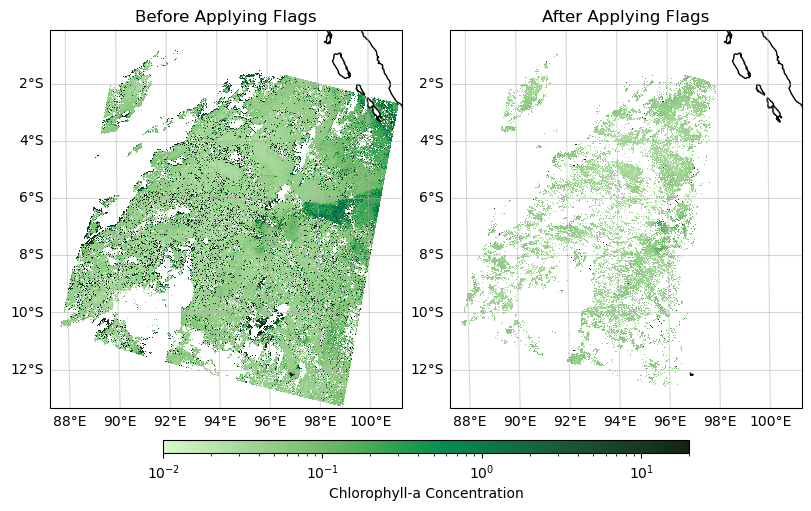

In [24]:
fig, ax = plt.subplots(figsize=[8,6], ncols = 2, layout='constrained', subplot_kw=dict(projection=ccrs.Robinson(central_longitude=112.0)))

for i in range(2):
    ax[i].coastlines()
    ini = ax[i].gridlines(draw_labels = True, alpha=0.5)
    ini.top_labels = False
    ini.right_labels = False
    if not i == 0:
        ini.left_labels == False

asl_plot.plot(ax=ax[0], x='longitude',y='latitude', add_colorbar=False, norm=colors.LogNorm(0.01,100), cmap=cmo.algae, transform=ccrs.PlateCarree(), zorder=0)
ax[0].set_title("Before Applying Flags")
chl_plot.plot(ax=ax[1], x='longitude',y='latitude', add_colorbar=False, norm=colors.LogNorm(0.01,100), cmap=cmo.algae, transform=ccrs.PlateCarree(), zorder=0)
ax[1].set_title("After Applying Flags")

cbar = plt.colorbar(cm.ScalarMappable(norm=colors.LogNorm(0.01,20), cmap=cmo.algae), shrink=0.7, aspect=40, pad=0.02, orientation = 'horizontal', label = 'Chlorophyll-a Concentration',ax=ax[0:])

In [25]:
reggridded = cdo.sellonlatbox(bbox_str, input = dta, returnXDataset = True)

# reggridded = cdo.remapcon(gridfile, input = bounded_dataset, returnXDataset = True)

In [26]:
reggridded.to_netcdf(os.path.join(result_dir , data_id + '.nc'))

regrid = xr.open_dataset(os.path.join(result_dir , data_id + '.nc'))

print(regrid)

<xarray.Dataset> Size: 25MB
Dimensions:    (time: 1, rows: 621, columns: 1667)
Coordinates:
  * time       (time) datetime64[ns] 8B 2023-09-01T03:26:32.400000
    longitude  (rows, columns) float64 8MB ...
    latitude   (rows, columns) float64 8MB ...
Dimensions without coordinates: rows, columns
Data variables:
    chl_flag   (time, rows, columns) float32 4MB ...
    CHL_NN     (time, rows, columns) float32 4MB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Jul 09 10:20:50 2024: cdo -O -s -f nc -sellonlatbox,97....
    CDO:          Climate Data Operators version 2.4.1 (https://mpimet.mpg.de...

In [27]:
chl_plot = 10 ** regrid['chl_flag']

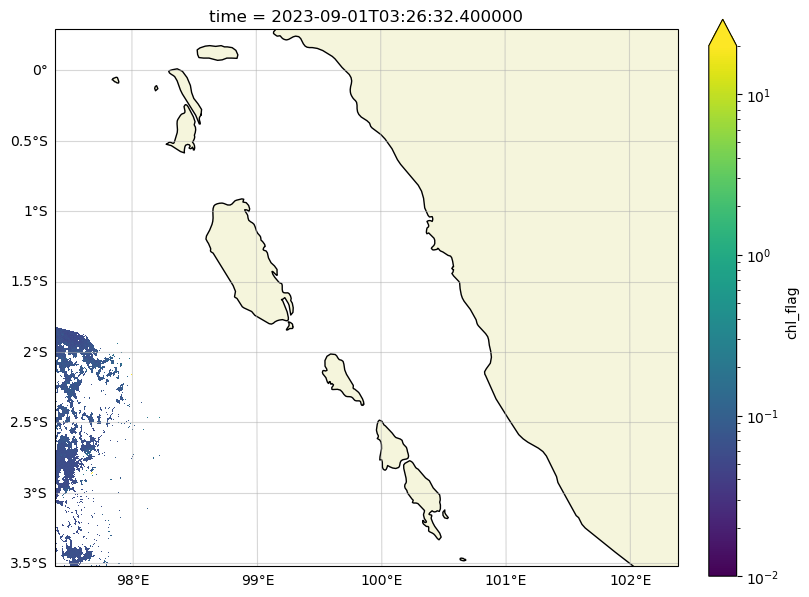

In [28]:
import cartopy

fig, ax = plt.subplots(figsize=[8,6], layout='constrained', subplot_kw=dict(projection=ccrs.Robinson(central_longitude=112.0)))

ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cf.LAND.with_scale('10m'), facecolor = 'beige', edgecolor='black', zorder = 1)
#ax.coastlines()
ini = ax.gridlines(draw_labels = True, alpha=0.5)
ini.top_labels = False
ini.right_labels = False

chl_plot.plot(ax=ax, x='longitude', y='latitude', norm=colors.LogNorm(0.01,21), transform=ccrs.PlateCarree(), zorder=0)

In [29]:
cdo.cleanTempDir()
gc.collect()

2961

In [30]:
shutil.rmtree(download_dir)